# AIFFELTHON -  [WONJIN]

## To do list

## 1. Pre-processing (Librosa, Scipy)

- Zero padding, 7secs
- Down sampling (sr= 16000(정인님팀 4000))
- Butter worth

## 2. Augmentation (Tensorflow-io + nlpaug ) on training data

- Shift Augmenation
- Speed Augmenation
- Pitch Augmentation
- Normalization


## 3. Feature Extraction

- Frequency masking
- Black Region Clipping

## 3. Modelling
- Resnet
- Transfer learning : Imagnet
: https://tensorflow.google.cn/tutorials/audio/transfer_learning_audio


## 4. Report


## 5. References

-  https://engineering.linecorp.com/ko/blog/voice-waveform-arbitrary-signal-to-noise-ratio-python/

- https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

- https://www.tensorflow.org/io/tutorials/audio



# Library Import

In [ ]:
from google.colab import drive
from os.path import join
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip uninstall tensorflow-io[tensorflow]

In [236]:
# !pip install tensorflow-io[tensorflow]

In [237]:
# !pip install nlpaug

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import librosa, librosa.display 
import librosa as lb
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Audio
import os
import tensorflow_io as tfio
from scipy import signal
from scipy.signal import butter, freqz, filtfilt, find_peaks 
import random

root = '/content/drive/MyDrive/hacker/aiffelthon/aiffelthon'
sr = 16000

# STEP 1. Sound file Upload


In [ ]:
# df_no_diagnosis = pd.read_csv('/content/drive/MyDrive/hacker/base_model/datasets/demographic_info.txt', names = 
#                  ['pid', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
#                  delimiter = ' ')
patient_data = pd.read_csv('/content/drive/MyDrive/hacker/base_model/datasets/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['pid', 'disease'])

In [ ]:
diagnosis=pd.read_csv('/content/drive/MyDrive/hacker/base_model/datasets/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
diagnosis.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
def getFilenameInfo(file):
    return file.split('_')

In [ ]:
import os
path='/content/drive/MyDrive/hacker/base_model/datasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['160_1b3_Ar_mc_AKGC417L',
 '160_1b2_Tc_mc_AKGC417L',
 '160_1b3_Pl_mc_AKGC417L',
 '160_1b3_Tc_mc_AKGC417L',
 '160_1b3_Pr_mc_AKGC417L']

In [ ]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,1.862,5.718,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
1,5.718,9.725,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Ar_mc_AKGC417L


In [ ]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')


In [ ]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,1.862,5.718,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD
1,5.718,9.725,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD
2,9.725,13.614,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD
3,13.614,17.671,0,1,160,mc,160_1b3_Ar_mc_AKGC417L,COPD
4,17.671,19.541,0,0,160,mc,160_1b3_Ar_mc_AKGC417L,COPD


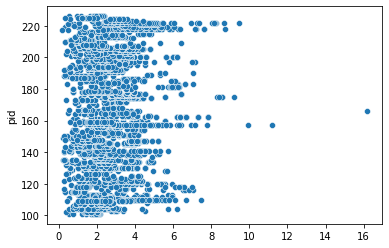

In [ ]:
import seaborn as sns
sns.scatterplot(x=(data.end - data.start), y=data.pid)

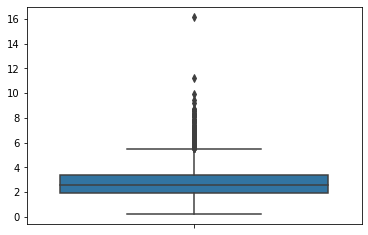

In [ ]:
sns.boxplot(y=(data.end - data.start))

https://preservsun.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AF-Box-Plot-1%EB%B6%84-%EC%9D%B4%ED%95%B4-%EC%A0%9C%EB%8C%80%EB%A1%9C-%EC%95%8C%EA%B3%A0-%EA%B0%80%EC%9E%90

#### 박스 플롯을 사용하는 이유

데이터 집합의 범위와 중앙값을 빠르게 확인할 수 있는 목적으로 사용되며, 많은 데이터를 눈으로 확인하기 어려울 때 그림을 이용해 확인 할 수 있는 장점과 통계적인 이상치(outlier)가 있는지도 확인이 가능하다.

# STEP 2. Audio Cutting & Padding

In [ ]:
def getPureSample(raw_data,start,end,sr=16000):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data)  
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
# import librosa as lb
# import soundfile as sf


# i,c=0,0

# filename2 = []
# start2 = []
# end2 = []
# pid2 = []
# mode2 = []
# disease2 = []
# crack_wheeze = []



# for index,row in data.iterrows():
#     maxLen=7
#     start=row['start']
#     end=row['end']
#     filename=row['filename']
    
#     #MaxLen의 길이에 맞게 오디오 파일을 잘라주는 기능을 함. 
#     # 데이터프레임에서 Start와 END를 인식함.

#     #If len > maxLen , change it to maxLen
#     if end-start>maxLen:
#         end=start+maxLen
    
#     audio_file_loc = path + filename + '.wav'
    
#     if index > 0:
#         #check if more cycles exits for same patient if so then add i to change filename
#         if data.iloc[index-1]['filename']==filename:
#             i+=1
#         else:
#             i=0
#     filename= filename + '_' + str(i) + '.wav' # for문에서 사용한 인덱스를 사용하여 각 wav파일에 번호를 붙임
    


# filename2.append(filename)
# start2.append(row['start'])
# end2.append(row['end'])
# pid2.append(row['pid'])
# mode2.append(row['mode'])
# disease2.append(row['disease'])

#     if row['crackles'] == 0 and row['weezels'] == 0:
#       crack_wheeze.append(0)
#     elif row['crackles'] == 1 and row['weezels'] == 0:
#       crack_wheeze.append(1)
#     elif row['crackles'] == 0 and row['weezels'] == 1:
#       crack_wheeze.append(2)
#     else:
#       crack_wheeze.append(3)


#     save_path='/content/drive/MyDrive/hacker/processed_audio_files/' + filename
#     c+=1
    
#     audioArr,sampleRate=lb.load(audio_file_loc)
#     pureSample=getPureSample(audioArr,start,end,sampleRate)
    
#     #pad audio if pureSample len < max_len
    
#     reqLen=7*sampleRate
#     padded_data = lb.util.pad_center(pureSample, reqLen)

#     #pad_center(data, 데이터를 포함한 인풋값길이)
    
#     sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
# print('Total Files Processed: ',c)


In [ ]:
'''
processed = pd.DataFrame(columns=['start','end','pid','mode','filename','disease','crack_wheeze'])
processed['start'] = start2
processed['end'] = end2
processed['pid'] = pid2
processed['mode'] = mode2
processed['filename'] = filename2
processed['disease'] = disease2
processed['crack_wheeze'] = crack_wheeze
processed.to_csv(root + 'processed.csv')
'''

"\nprocessed = pd.DataFrame(columns=['start','end','pid','mode','filename','disease','crack_wheeze'])\nprocessed['start'] = start2\nprocessed['end'] = end2\nprocessed['pid'] = pid2\nprocessed['mode'] = mode2\nprocessed['filename'] = filename2\nprocessed['disease'] = disease2\nprocessed['crack_wheeze'] = crack_wheeze\nprocessed.to_csv(root + 'processed.csv')\n"

In [ ]:
path2 = '/content/drive/MyDrive/hacker/processed_audio_files_7sec_22050/'

In [ ]:
filename1 = [s for s in os.listdir(path2) if '.wav' in s]
print (filename1[:2])
len(filename1)

['147_1b4_Tc_mc_AKGC417L_7.wav', '147_1b4_Tc_mc_AKGC417L_8.wav']


6898

In [ ]:
data2 = pd.read_csv('/content/drive/MyDrive/hacker/processed_audio_files/processed_csv/processed.csv')
data2.head()

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
0,0,1.862,5.718,160,mc,160_1b3_Al_mc_AKGC417L_0.wav,COPD,2
1,1,5.718,9.725,160,mc,160_1b3_Al_mc_AKGC417L_1.wav,COPD,3
2,2,9.725,13.614,160,mc,160_1b3_Al_mc_AKGC417L_2.wav,COPD,2
3,3,13.614,17.671,160,mc,160_1b3_Al_mc_AKGC417L_3.wav,COPD,2
4,4,17.671,19.541,160,mc,160_1b3_Al_mc_AKGC417L_4.wav,COPD,0


In [ ]:
data2.drop(['Unnamed: 0'], axis = 1)

,start,end,pid,mode,filename,disease,crack_wheeze
0,1.862,5.718,160,mc,160_1b3_Al_mc_AKGC417L_0.wav,COPD,2
1,5.718,9.725,160,mc,160_1b3_Al_mc_AKGC417L_1.wav,COPD,3
2,9.725,13.614,160,mc,160_1b3_Al_mc_AKGC417L_2.wav,COPD,2
3,13.614,17.671,160,mc,160_1b3_Al_mc_AKGC417L_3.wav,COPD,2
4,17.671,19.541,160,mc,160_1b3_Al_mc_AKGC417L_4.wav,COPD,0
...,...,...,...,...,...,...,...
6893,12.007,13.707,159,sc,159_1b1_Ll_sc_Meditron_7.wav,Healthy,0
6894,13.707,15.550,159,sc,159_1b1_Ll_sc_Meditron_8.wav,Healthy,0
6895,15.550,17.336,159,sc,159_1b1_Ll_sc_Meditron_9.wav,Healthy,0
6896,17.336,18.841,159,sc,159_1b1_Ll_sc_Meditron_10.wav,Healthy,0


In [ ]:
# filename_docs = []
filename_docs = []

for i in  data2.filename:
  path3 = path2 + i
  filename_docs.append(path3)

filename_docs [:2]

['/content/drive/MyDrive/hacker/processed_audio_files_7sec_22050/160_1b3_Al_mc_AKGC417L_0.wav',
 '/content/drive/MyDrive/hacker/processed_audio_files_7sec_22050/160_1b3_Al_mc_AKGC417L_1.wav']

In [ ]:
len(filename_docs)

6898

In [ ]:
# Noise 제거 전 기본 소리 들어보기 
audio, _ = lb.load(filename_docs[1], sr=sr)
Audio(audio, rate = 16000)

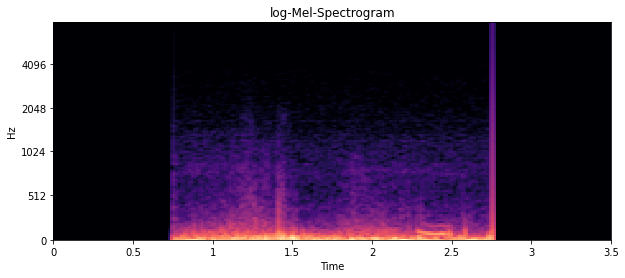

In [ ]:
mSpec_b=lb.feature.melspectrogram(y= audio, sr=sr)
log_mSpec_b = librosa.power_to_db(mSpec_b, ref=np.median)
plt.figure(figsize=(10, 4))
plt.title('log-Mel-Spectrogram') 
librosa.display.specshow(log_mSpec_b, x_axis="time", y_axis="mel", hop_length=256, sr=sr)

# Butter worth filter


In [ ]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
         nyq = 0.5 * fs
         low = lowcut / nyq
         high = highcut / nyq
         sos = butter(order, [low, high], analog=False, btype='band', output='sos')
         return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
         sos = butter_bandpass(lowcut, highcut, fs, order=order)
         y = sosfilt(sos, data)
         return y

In [ ]:
# low cut parameter 100으로 설정
butter_2 = []

for i in range(len(filename_docs)):
  sound_sample1, _ = lb.load(filename_docs[i], sr=sr) 
  butter_sample = butter_bandpass_filter(sound_sample1, 100, 2500, 16000)
  butter_2.append(butter_sample)

In [ ]:
# np.save( root +  '/butter_filter_lowcut100.npy', butter_2)

## Butter_Worth_Filter Test

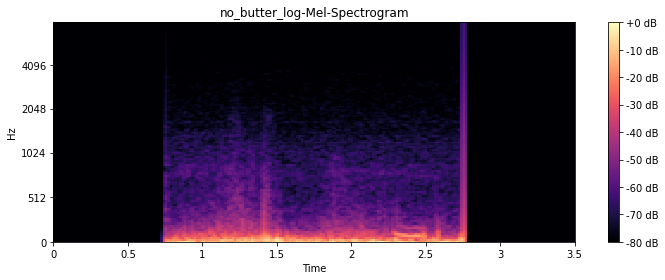

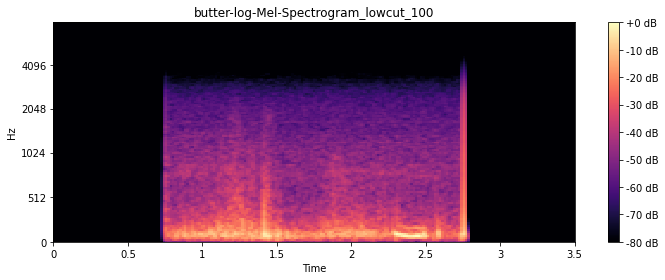

In [ ]:
# Butter worth filter 적용전
mSpec_b=lb.feature.melspectrogram(y= audio, sr=sr)
log_mSpec_b = librosa.power_to_db(mSpec_b, ref=np.max) 
plt.figure(figsize=(10, 4))
plt.title('no_butter_log-Mel-Spectrogram') 
librosa.display.specshow(log_mSpec_b, x_axis="time", y_axis="mel", hop_length=256, sr=sr)

plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


# low cut 100으로 설정
butter_mSpec_100=lb.feature.melspectrogram(y= butter_2[1], sr=sr)
log_mSpec_butter_100 = librosa.power_to_db(butter_mSpec_100, ref=np.max)
plt.figure(figsize=(10, 4))
plt.title('butter-log-Mel-Spectrogram_lowcut_100') 
librosa.display.specshow(log_mSpec_butter_100, x_axis="time", y_axis="mel", hop_length=256, sr=sr)

plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Low cut의 파라미터를 조정하여 결과를 확인하였을 때 음성과 멜스펙토그램에서 크게 차이는 없었으나 butter_worth filter을 적용 전과 후의 차이는 분명하였음.

### (2) 위의 파라미터값 Audio로 들어보기

In [ ]:
from IPython.display import Audio

# no butter fillter
Audio(audio, rate = 16000)  


In [ ]:
# Low cut 100
Audio(butter_2[1], rate = 16000)  

# STEP 3. Data separating



In [ ]:
#object인 레이블(정답)의 자료형을 모델에 넣기 위해 숫자로 변환
from sklearn.preprocessing import LabelEncoder
# le=LabelEncoder()
# ytrain=le.fit_transform(ytrain)
# yval=le.transform(yval)

In [ ]:
labels = np.array(data2.crack_wheeze)
labels

array([2, 3, 2, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain_1,Xval_1,ytrain_1,yval_1 = train_test_split(butter_2, labels, stratify= data2.crack_wheeze,random_state=42,test_size=0.2)

In [ ]:
len(Xtrain_1)

5518

In [ ]:
len(ytrain_1)

5518

In [ ]:
# Xtrain_1.to_csv(root + '/train.csv')
# Xval_1.to_csv(root + '/val.csv')

In [ ]:
# # 각 질병명 array형태로 0~7까지 라벨링되어 있음을 확인함
# sns.countplot(data2.disease)
# plt.xticks(rotation = 90)

In [ ]:
# audio = tfio.audio.AudioIOTensor(path2 + filename1[:1][0]) #뒤에 0은 리스트안에 요소를 가지고 올때 사용

# dir_list = os.listdir(path2)
# for i in dir_list:
#   path3 = path2 + i
#   # print(path3)

# Step4. Sound data Augmentation

#### **사용한 라이브러리** : Librosa [numpy.array or wave]

 
##  Augmentation (Tensorflow-io + nlpaug ) on training data
- Shift Augmenation
- Speed Augmenation
- Pitch Augmentation
- Frequency masking
- Time masking



http://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html

https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6

https://nlpaug.readthedocs.io/en/latest/augmenter/audio/shift.html

# Augumentation Test

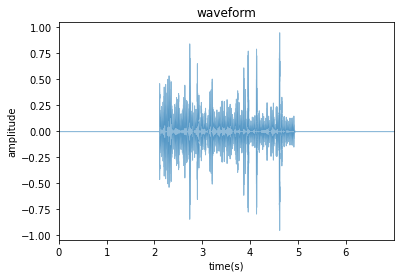

In [ ]:
librosa.display.waveplot(Xtrain_1[0], sr=sr, alpha = 0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("waveform")
plt.show()

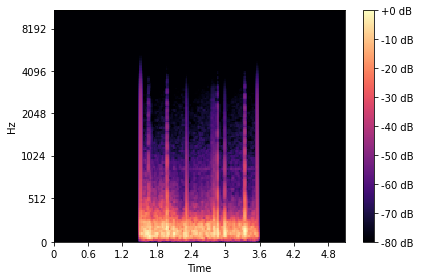

In [ ]:
mel_test = lb.feature.melspectrogram(Xtrain_1[0], sr)
mel_db = lb.power_to_db(mel_test, ref = np.max)


img = librosa.display.specshow(mel_db, y_axis = 'mel', x_axis = 'time')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Data based augumentation

In [ ]:
#본 split은 학습용이 아닌 라벨링 값을 균일하게 가져오기 위해 사용함.
Xtrain_aug,Xval_aug,ytrain_aug,yval_aug=train_test_split(data2, data2.crack_wheeze, stratify=data2.crack_wheeze, random_state=42,test_size=0.2)

데이터프레임에 filename에 있는 파일들은 전부 제로패딩되어있는 부분들이고 이거를 합쳐서 제로패딩을 해야함.

In [ ]:
Xtrain_aug['crack_wheeze'].value_counts()

0    2913
1    1491
2     709
3     405
Name: crack_wheeze, dtype: int64

In [ ]:
Xtrain_aug.head()

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
2103,2103,1.243,4.049,198,mc,198_6p1_Lr_mc_AKGC417L_1.wav,COPD,1
6340,6340,11.580,14.072,154,mc,154_2b4_Lr_mc_AKGC417L_4.wav,COPD,1
4914,4914,14.249,17.702,130,mc,130_3b3_Ll_mc_AKGC417L_4.wav,COPD,1
3596,3596,0.887,2.601,107,mc,107_2b3_Lr_mc_AKGC417L_0.wav,COPD,0
6739,6739,15.918,17.972,158,mc,158_1p4_Pr_mc_AKGC417L_7.wav,COPD,3


# (1) 클래스별 분류

In [ ]:
normal = Xtrain_aug.loc[Xtrain_aug['crack_wheeze'] == 0]
print ('정상인 호흡음의 갯수 : ', len(normal))

crackle = Xtrain_aug.loc[Xtrain_aug['crack_wheeze'] == 1]
print ('Crackle의 갯수 : ',len(crackle))

wheezing =  Xtrain_aug.loc[Xtrain_aug['crack_wheeze'] == 2]
print ('Wheezing의 갯수 : ',len(wheezing))

both = Xtrain_aug.loc[Xtrain_aug['crack_wheeze'] == 3]
print ('Crackle 및 wheezing 둘다 있는 경우의 갯수 : ',len(both))


정상인 호흡음의 갯수 :  2913
Crackle의 갯수 :  1491
Wheezing의 갯수 :  709
Crackle 및 wheezing 둘다 있는 경우의 갯수 :  405


In [ ]:
normal [:2]

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
3596,3596,0.887,2.601,107,mc,107_2b3_Lr_mc_AKGC417L_0.wav,COPD,0
2235,2235,3.297,7.805,200,mc,200_2p4_Lr_mc_AKGC417L_1.wav,COPD,0


In [ ]:
normal_docs = []
normal_audio_np = []

for i in normal.filename:
  path3 = path2 + i
  normal_docs.append(path3)

for j in range(len(normal_docs)):
  normal_audio,_ = librosa.load(normal_docs[j], sr = sr)
  normal_audio_np.append(normal_audio)

normal_audio_np[:2]

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

In [ ]:
crackle_docs = []
crackle_audio_np = []

for i in crackle.filename:
  path3 = path2 + i
  crackle_docs.append(path3)

for j in range(len(crackle_docs)):
  crackle_audio,_ = librosa.load(crackle_docs[j], sr = sr)
  crackle_audio_np.append(crackle_audio)

crackle_audio_np[:2]

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

In [ ]:
wheezing_docs = []
wheezing_audio_np = []

for i in wheezing.filename:
  path3 = path2 + i
  wheezing_docs.append(path3)

for j in range(len(wheezing_docs)):
  wheezing_audio,_ = librosa.load(wheezing_docs[j], sr = sr)
  wheezing_audio_np.append(wheezing_audio)

wheezing_audio_np[:2]

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

In [ ]:
both_docs = []
both_audio_np = []

for i in both.filename:
  path3 = path2 + i
  both_docs.append(path3)

for j in range(len(both_docs)):
  both_audio,_ = librosa.load(both_docs[j], sr = sr)
  both_audio_np.append(both_audio)

both_audio_np[:2]

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

In [ ]:
root_aug = '/content/drive/MyDrive/hacker/aug_norm/'

In [ ]:
# scale = 2
# aug_nos = scale * len(normal_audio_np) - len(normal_audio_np)
# # i,c = 0

# for i in range(aug_nos):

#   for index, row in normal.iterrows():
#     maxLen =7
#     start = row['start']
#     end = row['end']
#     filename = row['filename']

#     if end - start > maxLen:
#       end = start + maxLen

#     normal_file_aug = root_aug + filename 

#     filename = 'norm_' + str(i) + '_' + filename 

#     save_path = 'aug_norm/' + filename
    
#     normal_np, _ = lb.load(normal_docs, sr=sr)
#     pureSample = getPureSample(normal_np,start,end, sr=sr)

#    #padding
#     reqLen = 7*sr
#     padded_data = lb.util.pad_center(pureSample, reqLen)

#     sf.write(file=save_path, data = padded_data, samplerate =sr)

#   print('Nomral class processed : ', c)


In [ ]:
root_aug

'/content/drive/MyDrive/hacker/aug_norm/'

In [ ]:
import soundfile as sf

In [ ]:
# augment normal (test용)

# scale = 1
# aug_nos = scale * len(normal_audio_np) - len(normal_audio_np)

# for idx in range(10):
#   i = random.randint(0, len(normal_audio_np)-1)
#   j = random.randint(0, len(normal_audio_np)-1)

#   normal_i = normal_audio_np[i]
#   normal_j = normal_audio_np[j]
#   new_sample = np.concatenate([normal_i, normal_j])
#   filename= 'aug_normal' + '_' + str(idx) + '.wav'

#   sf.write(file = root_aug + filename , data=new_sample, samplerate = sr)

In [ ]:
# augment crackle (1422개의 wave파일을 추가 생성함)

scale = 1

aug_nos = scale * len(normal_audio_np) - len(crackle_audio_np)

for idx in range(aug_nos):
  aug_prob = random.random()

  if aug_prob < 0.6:
    #crakle_i + crackle_j
    i = random.randint(0,len(crackle_audio_np)-1)
    j = random.randint(0,len(crackle_audio_np)-1)
    sample_i = crackle_audio_np[i]
    sample_j = crackle_audio_np[j]

  elif aug_prob >= 0.6 and aug_prob < 0.8:
    # crakle_i + nomrmal_j
    i = random.randint(0,len(crackle_audio_np)-1)
    j = random.randint(0,len(normal_audio_np)-1)
    sample_i = crackle_audio_np[i]
    sample_j = normal_audio_np[j]

  else :
    # normal_i + crakcle_j
    i = random.randint(0,len(normal_audio_np)-1)
    j = random.randint(0,len(crackle_audio_np)-1)
    sample_i = normal_audio_np[i]
    sample_j = crackle_audio_np[j]

  new_sample = np.concatenate([sample_i, sample_j])

  filename= 'aug_crackle' + '_' + str(idx) + '.wav'

  sf.write(file = root_aug + filename , data=new_sample, samplerate = sr)


In [ ]:
# augment wheezing (2204개의 wave파일을 추가 생성함)

scale = 1

aug_nos = scale * len(normal_audio_np) - len(wheezing_audio_np)

for idx in range(aug_nos):
  aug_prob = random.random()

  if aug_prob < 0.6:
    # wheeze_i + wheeze_j
    i = random.randint(0,len(wheezing_audio_np)-1)
    j = random.randint(0,len(wheezing_audio_np)-1)
    sample_i = wheezing_audio_np[i]
    sample_j = wheezing_audio_np[j]

  elif aug_prob >= 0.6 and aug_prob < 0.8:
     # wheeze_i + normal_j
    i = random.randint(0,len(wheezing_audio_np)-1)
    j = random.randint(0,len(normal_audio_np)-1)
    sample_i = wheezing_audio_np[i]
    sample_j = normal_audio_np[j]

  else :
    # normal_i + wheeze_j
    i = random.randint(0,len(normal_audio_np)-1)
    j = random.randint(0,len(wheezing_audio_np)-1)
    sample_i = normal_audio_np[i]
    sample_j = wheezing_audio_np[j]

  new_sample = np.concatenate([sample_i, sample_j])

  filename= 'aug_wheezing' + '_' + str(idx) + '.wav'

  sf.write(file = root_aug + filename , data=new_sample, samplerate = sr)

In [ ]:
# augment both (2508개의 wave파일을 추가 생성함)

scale = 1

aug_nos = scale * len(normal_audio_np) - len(both_audio_np)

for idx in range(aug_nos):
  aug_prob = random.random()

  if aug_prob < 0.5:
    # both_i + both_j
    i = random.randint(0,len(both_audio_np)-1)
    j = random.randint(0,len(both_audio_np)-1)
    sample_i = both_audio_np[i]
    sample_j = both_audio_np[j]

  elif aug_prob >= 0.5 and aug_prob < 0.7:
     # crackle_i + wheeze_j
    i = random.randint(0,len(crackle_audio_np)-1)
    j = random.randint(0,len(wheezing_audio_np)-1)
    sample_i = crackle_audio_np[i]
    sample_j = wheezing_audio_np[j]

  elif aug_prob >= 0.7 and aug_prob < 0.8:
     # wheeze_i + crackle_j
    i = random.randint(0,len(wheezing_audio_np)-1)
    j = random.randint(0,len(crackle_audio_np)-1)
    sample_i = wheezing_audio_np[i]
    sample_j = crackle_audio_np[j]

  elif aug_prob >= 0.8 and aug_prob < 0.9:
    # both_i + normal_j
    i = random.randint(0,len(both_audio_np)-1)
    j = random.randint(0,len(normal_audio_np)-1)
    sample_i = both_audio_np[i]
    sample_j = normal_audio_np[j]

  else:
    # normal_i + both_j
    i = random.randint(0,len(normal_audio_np)-1)
    j = random.randint(0,len(both_audio_np)-1)
    sample_i = normal_audio_np[i]
    sample_j = both_audio_np[j]

  new_sample = np.concatenate([sample_i, sample_j])

  filename= 'aug_both' + '_' + str(idx) + '.wav'

  sf.write(file = root_aug + filename , data=new_sample, samplerate = sr)


In [ ]:
root

'/content/drive/MyDrive/hacker/aiffelthon/aiffelthon'

# Aug한 wave들 패딩 및 7초 맞추기 작업

In [224]:
both_docs = ('/content/drive/MyDrive/hacker/aug_both/')
both_docs1 ='/content/drive/MyDrive/hacker/both_padded_audio_files/'

In [ ]:
both_list = []

dir_list = os.listdir(both_docs)
for i in dir_list:
  path4 = both_docs + i
  both_list.append(path4)

In [ ]:
both_list[:2]

['/content/drive/MyDrive/hacker/aug_both/aug_both_0.wav',
 '/content/drive/MyDrive/hacker/aug_both/aug_both_1.wav']

In [ ]:
both_sound_array_list = []

for i in range(len(both_list)):
  bothaudioArr,_ = librosa.load(both_list[i], sr=sr)
  both_sound_array_list.append(bothaudioArr)

In [227]:
#pad audio if pureSample len < max_len

for idx in range(len(both_sound_array_list)):
  reqLen=7*sr
  pureSample=getPureSample(bothaudioArr, start, end, sr=sr)
  padded_data = lb.util.pad_center(pureSample, reqLen)
  filename_pad = 'aug_both_padded'+ '_' + str(idx) + '.wav'

  sf.write(file= both_docs1 + filename_pad, data=padded_data, samplerate=sr)


In [234]:
both_padded_audio_files = '/content/drive/MyDrive/hacker/both_padded_audio_files'

In [235]:
#만들어진 padded 데이터 갯수확인
len(os.listdir(both_padded_audio_files))

2508

# Audio Shifting augumentation

- direction값과 duration parameter들을 조정하면서 어떻게 변하는지 테스트함.

In [ ]:
# # 함수로 바로 사용할 경우 
# def audio_shift(signal, sr):
#     aug = naa.ShiftAug(sampling_rate=sr, duration=1, direction='left') #duration (float) – Max shifting segment (in second)
#     return aug.augment(signal)

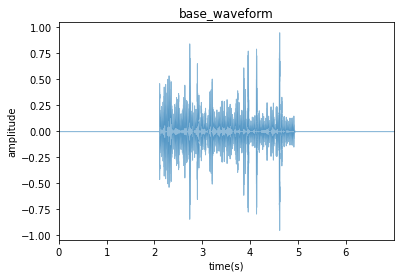

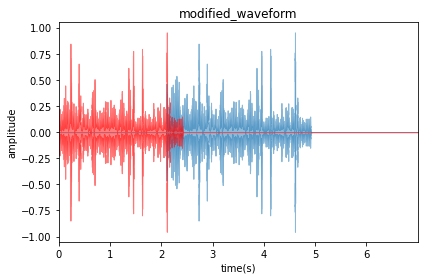

In [ ]:
import librosa.display as lbd

# base
librosa.display.waveplot(Xtrain_1[0], sr=sr, alpha = 0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("base_waveform")
plt.show()

# duration2.5 & random
aug1 = naa.ShiftAug(sampling_rate=sr,duration=2.5, direction='random')
augmented_data1 = aug1.augment(Xtrain_1[0])
lbd.waveplot(Xtrain_1[0], sr=sr, alpha=0.5)
lbd.waveplot(augmented_data1, sr=sr, color='r', alpha=0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("modified_waveform")

plt.tight_layout()
plt.show()

direction 값을 random 으로 줬을 때 기존 오디오 값 파란색을 기준으로 ShiftAug값들이 좌우로 이동되는 것을 확인 할 수 있음.

duration을 적용하면 기존 오디오 값에 값들이 겹치는 것을 확인할 수 있음

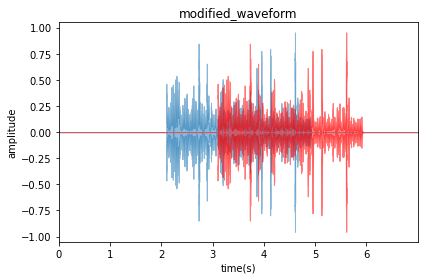

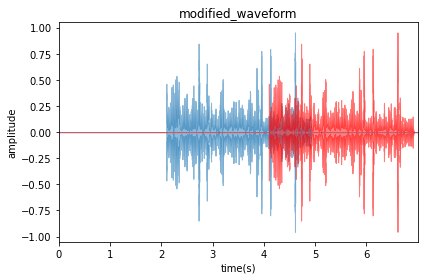

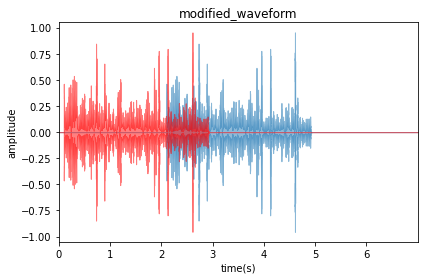

In [ ]:
# direction은 left로 일관적으로 적용하며 duration 1과 2의 차이를 살펴봄.

# duration1 & left
aug1 = naa.ShiftAug(sampling_rate=sr,duration=1, direction='left')
augmented_data1 = aug1.augment(Xtrain_1[0])
lbd.waveplot(Xtrain_1[0], sr=sr, alpha=0.5)
lbd.waveplot(augmented_data1, sr=sr, color='r', alpha=0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("modified_waveform")

plt.tight_layout()
plt.show()

#direction = left, duration =2
aug2 = naa.ShiftAug(sampling_rate=sr,duration=2, direction='left')
augmented_data2 = aug2.augment(Xtrain_1[0])

lbd.waveplot(Xtrain_1[0], sr=sr, alpha=0.5)
lbd.waveplot(augmented_data2, sr=sr, color='r', alpha=0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("modified_waveform")

plt.tight_layout()
plt.show()


#direction = right, duration =2
aug3 = naa.ShiftAug(sampling_rate=sr,duration=2, direction='right')
augmented_data3 = aug3.augment(Xtrain_1[0])

lbd.waveplot(Xtrain_1[0], sr=sr, alpha=0.5)
lbd.waveplot(augmented_data3, sr=sr, color='r', alpha=0.5)
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("modified_waveform")

plt.tight_layout()
plt.show()

이 역시 기존 오디오의 값과 축은 바뀌지 않으나 duration의 1과 2의 차이를 살펴보았을 때, augumentation 된 값(빨강)의 크기가 증가되기 보다는 time이 1만큼 이동되는 것을 확인할 수 있음.

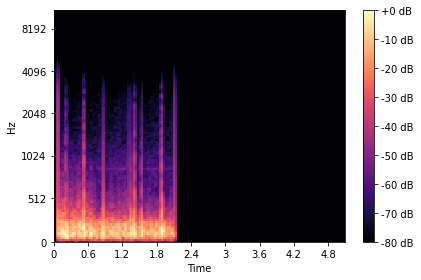

In [ ]:
mel_test = lb.feature.melspectrogram(augmented_data3, sr)
mel_db = lb.power_to_db(mel_test, ref = np.max)


img = librosa.display.specshow(mel_db, y_axis = 'mel', x_axis = 'time')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [ ]:
mel_test.shape

(128, 219)

# Audio test 해보기

- tensorflow라이브러리여도 인풋값은 array형태로 받을 수 있음.

In [ ]:
# 우선 nlpaugu라이브러리가 input으로 array형태로 받기 때문에 텐서로 변환하기
Audio_tensor = tf.data.Dataset.from_tensor_slices(Xtrain_1[0])

In [ ]:
# 기본음 
Audio(Xtrain_1[0], rate = 16000)

In [ ]:
# duration1 & left
Audio(augmented_data1, rate = 16000)

In [ ]:
# duration2 & left
Audio(augmented_data2, rate = 16000)

In [ ]:
# duration2 & right

Audio(augmented_data3, rate = 16000)

duration을 조정함으로써 사운드 차이가 있음을 인지하지는 못하였으나, direction을 left와 right함에 있어 차이가 있음을 확인 할 수 있었음.

결론적으로, 테스트를 해보면서 

In [ ]:
sig = audio_shift(Xtrain_1[0], sr = 16000)

NameError: ignored

In [ ]:
aug

In [ ]:
aug = naa.ShiftAug(Xtrain_1[0],  direction='random')
augmented_data = aug.augment(aug)


librosa.display.waveplot(aug, sr=sr, color='r', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
augmented_signal = add_white_noise(butter_filter_1, 0.1)
sf.write(augmented_signal, samplerate= sr)
signal_augmented = _plot_signal_and_augmented_signal(butter_filter_1, augmented_signal, sr)

In [ ]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
  fig, ax = plt.subplots(nrows=2)
  librosa.display.waveplot(signal, sr=sr, ax=ax[0])
  ax[0].set(title ='Original signal')
  librosa.display.waveplot(augmented_signal, sr=sr, ax=ax[1])
  ax[1].set(title = 'Agumented signal')
  plt.show()

In [ ]:
a = '/content/drive/MyDrive/hacker/processed_audio_files_7sec_22050/101_1b1_Al_sc_Meditron_0.wav'
b = np.array(a)

In [ ]:
for i in range(len(tensor_list)):
  position = tfio.audio.trim(tensor_list[i], axis=0, epsilon = 0.1)
  start = position[0]
  stop = position[1]
  print(start, stop)
  processed = tensor[start:stop]
  
  if i < 3:
    plt.figure()
    plt.plot(processed.numpy())

In [ ]:
for i in range(len(tensor_list)):
  position = tfio.audio.trim(tensor_list[i], axis=0, epsilon = 0.1)
  start = position[0]
  stop = position[1]
  print(start, stop)
  processed = tensor[start:stop]
  
  if i < 3:
    plt.figure()
    plt.plot(processed.numpy())

In [ ]:
len(Xtrain_1)

In [ ]:
audio

# Black_Region_Masking

In [ ]:
import cv2
n_mels=128
f_min=100
f_max=16000
nfft=2048
hop= nfft//4
resz=1
dump_images = False

In [ ]:
def create_mel_raw(current_window, sr=16000, n_mels=128, f_min=100, f_max=16000, nfft=2048, hop=512, resz=1):
    S = lb.feature.melspectrogram(y=current_window, sr=sr, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
    S = lb.power_to_db(S, ref=np.median)
    S = (S-S.min()) / (S.max() - S.min()) # Normalization
    S *= 255 # 픽셀을 표현하는 int8의 크기
    img = cv2.applyColorMap(S.astype(np.uint8), cmapy.cmap('magma'))
    height, width, _ = img.shape
    if resz > 0: # 이부분도 이해가 잘안됨 resz 1마다 무슨차이가 있는걸까? 1로 했을 때 출력(128,219,3) / 2로 했을 때 (256,438,3) /3으로 했을 때 (384, 657,3) -> 왜 2에서 3으로 설정했을 때는 2배 증가하는 것이 아닐까?
        img = cv2.resize(img, (width*resz, height*resz), interpolation=cv2.INTER_LINEAR) #비율에 맞춰서 조절하는 것을 상대크기를 확인하여 조절하는데 왜 절대크기만 정의해주었을까?
    img = cv2.flip(img, 0) # 상하 반전 함수 (1이면 이미지를 좌우 반전시킴)
    return img

In [ ]:
pip install cmapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cmapy: filename=cmapy-0.6.6-py3-none-any.whl size=3959 sha256=3f0e187a4627a76ace15649ec7738aa47b843b0234ae8dedea87ed73156235b5
  Stored in directory: /root/.cache/pip/wheels/49/9a/c8/486d47fd07a9ca1b91602dd040f727313dbeaa059a45d77521
Successfully built cmapy


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


(128, 219, 3)

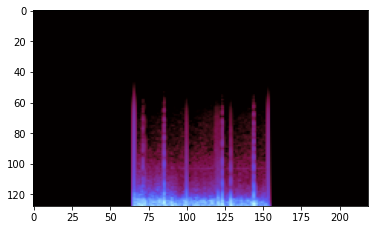

In [ ]:
import cmapy
# resz 크기를 1로 했을 때 #크기가 128,219,3이라는데 왜 너비가 128 같지가 않을까..?
test_img = create_mel_raw(Xtrain_1[0], sr)
plt.imshow(test_img)
test_img.shape

In [ ]:
#BGR 을 RGB로 바꿈.
audio_image = cv2.cvtColor(create_mel_raw(Xtrain_1[0], sr, n_mels, f_min, f_max, nfft, hop, resz=3), cv2.COLOR_BGR2RGB) # 위의 resz 파라미터 1과 3을 조정하는게 관건인듯
# (384, 657, 3)


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


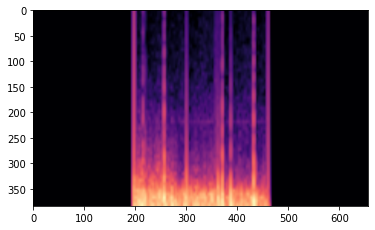

In [ ]:
#blank region clipping
audio_raw_gray = cv2.cvtColor(create_mel_raw(Xtrain_1[0], sr, n_mels, f_min, f_max, nfft, hop), cv2.COLOR_BGR2GRAY) # 이건 또 BGR를 Gray로 바꿧네??

#이미지 프로세싱에서 색상은 필요로 하지 않을 경우 노이즈라고 생각하며, 속도,색상인식과 3채널로 다시 바꿧을때 영상처리에 대한 insight를 제공하는데 도움줌.

audio_raw_gray[audio_raw_gray < 10] = 0 # 여기서 왜 10보다 작은 수치일까
for row in range(audio_raw_gray.shape[0]):

# 128라는 건 이미지의 너비를 말하는 듯함. 근데 왜 높이가 아니라 너비를 쓰는 거지?

    black_percent = len(np.where(audio_raw_gray[row,:]==0)[0])/len(audio_raw_gray[row,:]) # 173/219 = 0.7899543378995434
    if black_percent < 0.80: # 위 출력값에서 80미만인 79가 나옴. 음 머리에 안그려지네..ㅋ
        break

if (row+1)*3 < audio_image.shape[0]:     # 384수치RGB값으로 멀하는 거지 머하는 코드인고.. 채널을 늘려주는 건가 3을 곱해서?? RGB인데 굳이?
    audio_image = audio_image[(row+1)*3:, :, :] # (171,657,3) 


audio_image = cv2.resize(audio_image, (audio_image.shape[1], n_mels*3), interpolation=cv2.INTER_LINEAR) # (384, 657, 3) # 절대너비는 657이 되어야하고, 높이는 384가 되어야하는데 왜바꼇지
plt.imshow(audio_image)

# if dump_images:
#   save_images((audio_image, self.audio_data[index][2], self.audio_data[index][3], self.audio_data[index][5], self.audio_data[index][1]), self.train_flag)

In [ ]:
audio_image.shape

(384, 657, 3)

In [ ]:
audio_raw_gray.shape

(128, 219)

In [ ]:
black_percent 

0.7899543378995434

In [ ]:
# audio_raw_gray[row,:] # 행 전체를 슬라이싱?

In [ ]:
a = np.array ([[15,8,12],[11,7,3]])
a.shape
a

In [ ]:
b = a[1,:]
b

In [ ]:
c = a[:,1]
c

In [ ]:
def getSounds(path):
    soundArr,sr=lb.load(path3)
    return soundArr

In [ ]:
Xtrain_a=[]
for idx,row in Xtrain.iterrows():
    path=path3 + row['filename']
    c=getSounds(path)
    Xtrain_a.append(c)

Xtrain_array=np.array(Xtrain_a)

In [ ]:
Xval_a =[]
for idx, row in Xval.iterrows():
  path_1 = path3 + row['filename']
  d=getSounds(path_1)
  Xval_a.append(d)

Xval_array = np.array(Xval_a)

In [ ]:
mSpec=lb.feature.melspectrogram(Xtrain_a[10],sr=sr)
log_mSpec = librosa.power_to_db(mSpec, ref=np.median)
librosa.display.specshow(log_mSpec, x_axis="time", y_axis="mel", hop_length=512, sr=sr)
plt.title('log-Mel-Spectrogram_hop_length_512') 
plt.figure(figsize=(10, 4))

librosa.display.specshow(log_mSpec, x_axis="time", y_axis="mel", hop_length=256, sr=sr)
plt.title('log-Mel-Spectrogram_hop_length_256') 
plt.figure(figsize=(10, 4))
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()

In [ ]:
MFCCS = librosa.feature.mfcc(Xtrain_a[10], sr, n_fft =2048, hop_length=512, n_mfcc=13  )
plt.figure(figsize = (15,10))
librosa.display.specshow(MFCCS, sr=sr, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")
plt.show()


In [ ]:
# # # TensorFlow IO 라이브러리를 통하여 augmentation 수행하기
# # # arg를 그냥 파일이름을 넣어줘야되는게 아니라 경로로 넣어줘야되며 리스트를 제거해줘야됨
# audio = tfio.audio.AudioIOTensor(a)

In [ ]:
# # !pip uninstall tensorflow
# # !pip uninstall tensorflow-io
# # !pip install tensorflow-gpu
# !pip install tensorflow-io[tensorflow]

In [ ]:
tensor_list = []

for i in range(len(path3)):
  audio1 = tfio.audio.AudioIOTensor(path3)
  audio_slice = audio1[:] #여기서 100의 의미는 무엇일까?
  audio_tensor = tf.squeeze(audio_slice, axis=[-1]) # # remove last dimension
  tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
  tensor_list.append(tensor) 

  # print('슬라이싱 했을 때 : ', audio_slice[:2])
  # print('탠서로 변환했을 때: ', audio_tensor[:2])
  # print('텐서의 형태를 변환 햇을 때 : ', tensor[:2])

# tf.squeeze는 텐서모양에서 크기 1의 모든 치수가 제거 된 동일한 유형의 텐서를 반환함.
# 모든 크기 1 치수를 제거하지 않으려면 axis 를 지정하여 특정 크기 1 치수를 제거 할 수 있습니다

# int16타입의 154350개의 샘플을 갖는 모노채널임을 의미 #아마 제로 패딩을 하여 이렇게 나왔으라 생각함.

# 32768 is 2^15. int16 has a range of -32768 to +32767. 
# If you have int16 as input and divide it by 2^15, you get a number between -1 and +1.
# tf.cast : 텐서를 새로운 형태로 캐스팅하는데 사용하며, 부동소수점형에서 정수형으로 바꾼 경우 소수점을 버림
# Boolean 형태인 경우 true이면 1, false 0을 출력함

In [ ]:
Xtrain_a[10]

In [ ]:
# 하나만 뽑아서 확인해보기 

# for i in range(len(tensor_list[:1])):
#   plt.figure()
#   plt.plot(tensor.numpy())

## STEP 4-1 Noise triming

In [ ]:
def gen_augmented(original, sr):
	# list of augmentors available from the nlpaug library
	augment_list = [
	#naa.CropAug(sampling_rate=sample_rate)
	naa.NoiseAug(),
	naa.SpeedAug(),
	naa.LoudnessAug(factor=(0.5, 2)),
	naa.VtlpAug(sampling_rate=sample_rate, zone=(0.0, 1.0)),
	naa.PitchAug(sampling_rate=sample_rate, factor=(-1,3))
	]
	# sample augmentation randomly
	aug_idx = random.randint(0, len(augment_list)-1)
	augmented_data = augment_list[aug_idx].augment(original)
	return augmented_data

#Same as above, but applies it to a list of samples
def augment_list(audio_with_labels, sample_rate, n_repeats):
    augmented_samples = []
    for i in range(n_repeats):
        addition = [(gen_augmented(t[0], sample_rate), t[1], t[2], t[3], t[4]+i+1 ) for t in audio_with_labels]
        augmented_samples.extend(addition)
    return augmented_samples

In [ ]:
for i in range(len(tensor_list)):
  position = tfio.audio.trim(tensor_list[i], axis=0, epsilon = 0.1)
  start = position[0]
  stop = position[1]
  print(start, stop)
  processed = tensor[start:stop]
  
  if i < 3:
    plt.figure()
    plt.plot(processed.numpy())

# Noise triming 비교

In [ ]:
# 위와 비교해보기 
for i in range(len(tensor_list[:1])):
  plt.figure()
  plt.plot(tensor.numpy())

In [ ]:
position1 = np.array(position, dtype = 'float32')

In [ ]:
processed.dtype

In [ ]:
# 스펙토그램 비교해보기
#(1) 기존 제로 패딩

base =   tfio.audio.spectrogram(tensor, nfft=2048, window=2048, stride=512)
plt.figure(figsize = (10,10))
plt.imshow(tf.math.log(base).numpy())

# (2) noise triming
trimo =   tfio.audio.spectrogram(processed, nfft=2048, window=2048, stride=512) 
plt.figure(figsize = (10,10))
plt.imshow(tf.math.log(trimo).numpy())
           

## STEP 4-2 Fading in & Fading out

After fading in, we can listen to a low-frequency sound.

In [ ]:
# 오디오 신호를 점차적으로 늘리거나 줄이는

# for i in range(len(processed)):
#   fade = tfio.audio.fade(processed, fade_in=2500, fade_out=2000, mode="logarithmic")
#   if i <3:
#     plt.figure()
#     plt.plot(fade.numpy())

In [ ]:
# 위에 전처리 부분이 시간이 오래걸려 텐서를 넘파이로 중간 저장함
np.save(root + 'fadding.npy', fade)

In [ ]:
fadding = np.load('/content/drive/MyDrive/hacker/aiffelthon/aiffelthonfadding.npy')

In [ ]:
upload = tf.data.Dataset.from_tensor_slices(fadding)
upload

In [ ]:
# from IPython.display import Audio

# Audio( audio_tensor.numpy(), rate=audio.rate.numpy()  )

In [ ]:
# Convert to spectrogram
c =0

for i in range(len(upload)):
  spectrogram = tfio.audio.spectrogram(fadding, nfft=2048, window=2048, stride=512)

  # if i < 3:
  #   plt.figure(figsize = (10,10))
  #   plt.imshow(tf.math.log(spectrogram).numpy())

  # c += 1

  # if c % 500 == 0:
  #  print(c)

In [ ]:
np.save( root +  'spectrogram.npy', spectrogram)

In [ ]:


spectrograming = np.load('/content/drive/MyDrive/hacker/aiffelthon/aiffelthonspectrogram.npy')
spectrogram1 = tf.data.Dataset.from_tensor_slices(spectrograming)
spectrogram1

# Mel-spectrogram

In [ ]:
for i in range(len(spectrogram1)):

  # Convert to mel-spectrogram
  mel_spectrogram = tfio.audio.melscale(spectrograming, rate=16000, mels=128, fmin=0, fmax=8000 )

  # Convert to db scale mel-spectrogram
  dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)


  # if 3  < i:
  #   plt.figure(figsize = (10,10))
  #   plt.imshow(tf.math.log(mel_spectrogram).numpy())
  #   plt.imshow(dbscale_mel_spectrogram.numpy())


# mel_spectrogram = tfio.audio.melscale(
#     spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


# Convert to db scale mel-spectrogram
# dbscale_mel_spectrogram = tfio.audio.dbscale(
#     mel_spectrogram, top_db=80)



In [ ]:
dbscale_melspectrogram = np.save (root + 'dbscale_mel_spectrogram.npy',dbscale_mel_spectrogram )

In [ ]:
# 중간에 인터넷이 끊겼는데 혹시나 문제있으면 앞에 셀 다시 돌려볼 것
dbscale = np.load('/content/drive/MyDrive/hacker/aiffelthon/aiffelthondbscale_mel_spectrogram.npy')
dbscale1 = tf.data.Dataset.from_tensor_slices(dbscale)
dbscale1

## STEP 4-3 Frequency masking

In frequency masking, we eliminate quieter sounds from the sound to make the audio file clearly audible.


주파수 채널 [f0, f0 + f)이 마스킹됩니다. 여기서 f는 0부터 주파수 마스크 매개변수 F까지의 균일한 분포에서 선택되고 f0은 (0, ν − f)에서 선택됩니다. 여기서 ν는 주파수 채널의 수입니다.

In [ ]:
# Freq masking
for i in range(len(dbscale1)):
  freq_mask = tfio.audio.freq_mask(dbscale, param=10)

  if 3 < i :
    plt.subplot(2,1)
    plt.figure(figsize = (5,10))
    plt.imshow(freq_mask.numpy())

In [ ]:
len(dbscale1)
len(freq_mask)

# STEP 4-4 Time masking

It can be the case, in an audio file, the presence of some quieter sounds are difficult to judge at the same time step. Time masking is a process of eliminating quieter sounds lying in the same time step from the audio. 

In [ ]:
# Time masking
for i in range(len(dbscale1)):
  time_mask = tfio.audio.time_mask(dbscale, param=10)

  if 3 < i :
    plt.figure(figsize = (5,5))
    plt.imshow(freq_mask.numpy())   

In [ ]:
Xtrain.to_csv(root + 'train.csv')
Xval.to_csv(root +'val.csv')

In [ ]:
np.save('/content/Masking_preprocessing.npy' +'Masking_preprocessing.npy',time_mask)

In [ ]:
mSpec_train = np.load('/content/Masking_preprocessing.npy' + 'Masking_preprocessing.npy')
mSpec_val = np.load('/content/Masking_preprocessing.npy' + 'Masking_preprocessing.npy')

In [ ]:
def getFeatures(path3):
    soundArr,sample_rate=lb.load(path3)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [ ]:
sr = 16000
randFiles = [10 * x for x in range(1,5)]

for i, audioFile in enumerate(randFiles):

  plt.figure(figsize=(10,4))
  plt.title('Mel_spectrogram')
  librosa.display.specshow(librosa.power_to_db(mSpec_train[audioFile], ref=np.max),  y_axis='mel', sr=sr, hop_length=512, x_axis='time')
  plt.colorbar(format='%+2.0f dB')

  plt.tight_layout()
  plt.savefig('Mel-Spectrogram example.png')
  plt.show()

# 여기까지만 참고!!

MFCC parameter 값

https://sanghyu.tistory.com/45

STFT parameter 값(amplitude, n_fft(win_length보다 길 경우 모두 zero padding해서 처리하기 위한 파라미터), win_length(FFT를 수행할 시간간격), hop_length(시간 해상도를 나타내는 값))

n_fft ; frequency 영역대를 얼마만큼 둘것이냐->퓨리에 변환을 몇개 할것이냐를 둠. 

https://hyongdoc.tistory.com/401?category=884319
https://kaen2891.tistory.com/39

FFT를 할때 특정 주기간격으로 시행하게되는데 이때 discontunity문제가 발생하며, STFT 라이브러리에서 default값 중의 하나인 hann은 그래프 양 끝구간을 0으로 만들어줌.


In [ ]:
# fft(fast Fourier transform)

fft = np.fft.fft(sound) # fft의 결과를 log와 linear로 그릴 수 있다, 
#즉, np.fft.fft(signal) 함수로 데이터를 FFT로 변환한 후 abs(s_fft) 함수로 변환된 값의 절대치를 만들었다.
# fft() 함수를 이용해 주파수 도메인으로 변환하면 실수와 복소수로 구성된 값으로 나오기 때문에 abs를 통해 절대치로 바꿔주면 된다.

#신호의 진동수와 감는 진동수가 일치하는 경우, 그래프의 높은 점은 모두 오른쪽에 몰리게되고, 낮은 점은 왼쪽에 몰리는 현상이 일어남

푸리에 변환에서 사용하는 주기함수는 sin, cos 삼각함수이며 푸리에 변환은 고주파부터 저주파까지 다양한 주파수 대역의 sin, cos 함수들로 원본 신호를 분해하는 것이다.

 주기함수 성분들은 고유의 주파수(frequency)와 강도(amplitude)를 가지고 있으며 이들을 모두 합치면 원본 붉은색 신호가 된다.

In [ ]:
fft[:5]  #여기서 j는 허수단위로서 (루트 -1로서, 회전하는 값임) 실수는 크기가 되고, 허수는 각(위치정보)를 표현하게 됨
# 또다른 말로, 실수부가 frequency영역대의 magnitude를 뜻, 허수부가 phase를 뜻함.
# 푸리에 변환은 신호를 서로 다른 frequency들의 합으로 표현해, waveform을 time domain에서 frequency domain으로 변환시킨다. 

#(1) 시간에 대한 세기 그래프 (2)2차원 공간에 말아놓은 감긴그래프 (3) 감는 진동수의 변화에 따른 무게중심의 위치의 그래프 

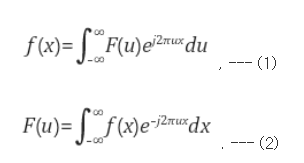

여기서 j는 허수단위 , f(x)는 원본 입력 신호, $e^j2πux$ 는 주파수 u인 주기함수 성분, F(u)는 해당 주기함수 성분의 계수(coefficient)를 나타낸다.



일단 식을 있는 그대로 해석하면 식 (1)은 입력신호 f(x)가 ej2πux들의 합으로 표현(분해)된다는 의미이다 (적분은 합한다는 의미를 갖는다). 그리고 식 (2)는 f(x)를 주기함수 성분으로 분해했을 때의 계수(coefficient) F(u)가 식 (2)로 주어진다는 의미이다. 앞서 그림 1과 연관해 보면 ej2πux는 f(x)를 구성하는 (파란색의 주파수 u인) 주기함수 성분들이고 F(u)는 해당 주기함수 성분의 강도(amplitude)를 나타낸다.



☞ 푸리에 변환에 대한 일반적인 설명 방식은 두번째 식 (2)를 푸리에 변환이라고 정의하고 첫번째 식 (1)을 푸리에 역변환(inverse Fourier transform)이라고 정의하는 것이다. 그리고 푸리에 역변환을 하면 다시 원래의 함수로 돌아온다고 한다. 하지만 이러한 기계적인 이해(푸리에 변환을 어디 하늘에서 뚝 떨어진 정의로만 받아들이는 것)는 푸리에 변환의 본질을 이해하는데 별 도움이 되지 않는다.



이제 식으로 좀더 들어가 보자. 일단, 식 자체는 푸리에 변환의 대단함에 비추어 매우 단순하다 (Simple is the best!!). 다만 한 가지 ej2πux의 의미만 이해하면 된다. 그리고 이를 위해서는 오일러 공식(Euler's formula)이 필요하다.



오일러 공식(Euler's formula)은 복소지수함수를 삼각함수로 변환할 수 있도록 하는 유명한 식이다.


더 자세한 풀이는 
https://darkpgmr.tistory.com/171

#### amplitude = abs(fft)*(2/len(fft))
#### frequency = np.fft.fftfreq(len(s_fft), T)

-> abs(fft) x (2/len(fft)) 와 같이 뒤쪽에 2/len(fft)를 곱해줬는데, 실제 amplitude를 구하기 위해서 scaling을 해준 것이다. np.fft.fftfreq(len(fft), T) 함수는 x축을 만들어 주기 위한 것으로 데이터의 개수는 신호의 개수(len(fft))와 일치시켜줘야 하고, 정확한 주파수 값을 얻기 위해서는 T(주기)를 입력해 주어야 한다.

#### 역푸리에 변환
: ifft를 이용하여 fft값을 인버스 하는 과정이다. 주의할 점은 fft변환 후 절대값(abs)을 취한 값이 아닌 fft변환 직후의 값을 인버스 해야 한다.
https://lifelong-education-dr-kim.tistory.com/4

In [ ]:
# 복소공간 값 절대값 취해서, magnitude구하기
magnitude = np.abs(fft) 

# 주파수값 만들기(linspace함수를 이용하면 지정된 간격 동안 균일 한 간격의 숫자를 반환함)
# 해석하자면, 0부터 샘플한값까지의 숫자를 반환하는데, 이때의 간격을 len(magnitude)로 설정함.
f= np.linspace(0,sr,len(magnitude)) 

# 푸리에 변환을 통과한 spectrum은 대칭구조로 나와서 high frequency부분 절반을 날리고 앞쪽 절반만 사용.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=(15,10))
plt.plot(left_f, left_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power Spectrum')

푸리에 변환 결과는 복소공간에 형성되어 실수부와 허수부로 나뉘게 된다. 이 값을 절댓값을 취해 magnitude로 사용한다. Frequency는 초당 주기의 반복 빈도 수 이므로, 초당 샘플갯수인 sr보다 클 수 없다. 따라서 0 ~ frequency 사이에서 len(magnitude) 만큼 frequency domain을 만들어 주자.

# STFT -> Spectrogram

STFT는 단순 푸리에 변환과 다르게 시간 정보를 보존하기 위해, frame 단위로 FFT를 수행한다. 따라서 frame 수와 frame 당 sample 수를 지정해주어야 한다. 또한 Spectrogram에서는 dB 값을 사용하므로, 푸리에 변환의 결과인 magnitude에 로그 Scaling을 통해 dB로 변환해준다.

n_ftt : fft를 수행할 갯수

window_length의 경우 n_fft와 같은 수로 하는것이 일반적입니다. 
hop_length = n_fft // 4, window_length = n_fft로 사용합니다.

In [ ]:
# https://towardsdatascience.com/all-you-need-to-know-to-start-speech-processing-with-deep-learning-102c916edf62

#STFT -> spectogram
hop_length = 512 # 전체 frame 수
n_fft = 2048 #위 fram하나당 sample 수

# calcurate duration hop length and window in secodns
hop_length_duration = float(hop_length)/sr
n_fft_duration = float(n_fft)/sr

# FT :전체 waveform에 푸리에 변환을하면 time domain이 사라져 해석에 어려움이 생김
#STFT는 위에서 자른 frame마다 푸리에 변환을 취해 각각을 시간 순으로 옆으로 쌓아 time domain을 살리기 위한 방법임
#FT는 시간에 흐름에 따라 신호의 수파수가 변했을때, 어느 시간대에 주파수가 변하는지 모르게 된다. 이러한 한계를 극복하기 위해서,
# STFT는 시간의 길이를 나눠서 이제 퓨리에 변환을 하게 됩니다. 즉 FFT를 했을때는 Time domina에 대한 정보가 날아가게 되는 것임.
#STFT의 결과는 즉 시간의 흐름(Window)에 따른 Frequency영역별 Amplitude를 반환하며,자른 Frame에 stft를 취하면, x축이 time에서 frequency로 바뀌며
# 이를 spectrum이라고 정의함.
#스펙트럼 y축 magnitude를 제곱한것이 power이고 이를, power spectrum이라고 이야기함.
#magnitude에 로그 스케일링을 통해 db로 만듬
stft = librosa.stft(sound, n_fft=n_fft, hop_length = hop_length)

#복소공간 값 절대값 취하기
magnitude = np.abs(stft)

#magnitude 에서 데시벨로 변환
log_spectrogram = librosa.amplitude_to_db(magnitude)

#display spectrogram
plt.figure(figsize= (15,10))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format="%+2.0f dB")
plt.title('Spectrogram(dB')



멜스펙토그램에 log를 취한 것을 다시 DCT(IFTT)를 적용하여 얻어진 Coefficients를 보면 허소수가생김 cos,sin으로 주기함수로 다시 표현 dct(stt선형변형임)

mel spectrogram을 DCT(Discrete Cosine Transform) 처리하면 얻게되는 coefficient를 말합니다. 쉽게 얘기하면, mel scale로 변환한 스펙트로그램을 더 적은 값들로 압축하는 과정이라고 볼 수 있습니다. 이미지를 압축하는 과정에서도 DCT를 사용하기도 합니다.

DCT (Discrete Cosine Transform)
DFT(Fourier) 대비 복소수 없이 실수로만 이루어져 있기 때문에 처리가 빨라 신호처리에서 사용한다고 합니다.

기본적으로 DCT는 코사인 변환입니다. 즉, 푸리에 변환과 마찬가지로 어떤 그래프(또는 이미지)가 있을 때, 그 그래프를 많은 코사인 함수로 표현한다고 볼 수 있습니다. 예를 들어 Mel-spectrogram에서 주파수 값이 총 1000개 였다면, 이를 그래프화한뒤 다시 주파수 분석을 하는 것입니다.
다시 생각해보면, 원래 음원 데이터의 RAW 데이터는 파형이라고 볼 수 있습니다. 이 복잡한 파형을, sr이 22050이라고 한다면, 초당 22050개의 점을 찍어서 만든 아주 거대한 데이터입니다.이를 주파수 분석을 하면 초당 1000개로 표현할 수 있게 됩니다. 즉, 데이터 크기의 압축이 일어나게 되며, 그 과정에서 손실이 발생합니다.
여기에서 그 주파수 분석된 결과를 또한번 주파수 분석한다고 이해해볼 수 있겠습니다. 그렇게 되면 원래 초당 22050개의 RAW데이터가 1000개로 축소되었는데, 이를 다시 20개로 축소할 수 있게 되는 것입니다.

DCT는 inverse 역변환이 가능하기 때문에, 결과적으로 20개의 값을 다시 RAW 데이터인 파형으로 돌릴 수 있습니다. 이렇게 데이터를 압축(손실압축)하는 방식이라고 볼 수 있습니다.

그렇게 압축된 데이터가 바로 MFCC, coefficient 입니다.
제가 이해한 것이 맞다면 원리는 설명한 바와 같습니다. 한번 더 깊게 생각해보면, 주파수 분석을 하게 되면 아주 작은 국소 구간에서의 값 편차는 DCT를 거칠 때 사라지게 될 것입니다. 코사인 함수의 주파수 단위로 분석하기 때문입니다. 이미지로 치면 비슷한 픽셀값들은 모두 동일한 값으로 처리되면서 압축이 될 것이며, 음원의 스펙트로그램으로 치면 비슷한 주파수 영역의 dB값은 모두 동일한 값으로 통일될 겁니다. 그렇게 데이터가 압축되고, 손실이 발생하는 구조입니다.

이 때 음원의 경우, MFCC를 거치면 노이즈가 제거된다고 볼 수도 있습니다. 사소하게 튀는 값들이 모두 DCT를 거치면서 압축/손실되기 때문입니다.

이렇게 MFCC를 통해 음원 혹은 음성 데이터의 주요 특징을 추출할 수 있다고 합니다. 추출된 요소가 바로 노이즈가 제거된 음원 데이터의 압축판이라고 볼 수 있지 않나 싶습니다.

Librosa로 MFCC 구현하기
Librosa에서는 RAW데이터인 음원을 바로 MFCC로 만들어주기도 하고, 혹은 그 중간과정인 STFT와 Mel-Scale 값을 받아서 만들어주기도 합니다. 기능을 다양하게 제공하니 정말 잘 만든 라이브러리인 것 같습니다.



출처: https://hyongdoc.tistory.com/403?category=884319 [Doony Garage]


# Mel Frequency Cepstral Coefficients(MFCC)

앞서 구한 Spectrogram이 아닌 spectrum에 Mel-filter bank를 통과시키고, log scaling 과 역푸리에 변환(IFFT)를 취해 Cepstrum Coefficient 중 낮은 12개만 선택한다. 여기에 Energy값을 더해 총 13개의 feature를 MFCC로 정의한다. 이를 1차 차분, 2차 차분한 값을 추가해 총 39차원 벡터로 MFCC를 가장 많이 사용한다.

In [ ]:
MFCCS = librosa.feature.mfcc(sound, sr, n_fft=n_fft, hop_length = hop_length, n_mfcc=13)

plt.figure(figsize = (15,10))
librosa.display.specshow(MFCCS, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")
plt.show()

dct는 n_mfcc(n개의 데이터)를 n개의 코사인 함수의 합으로 표현하여 데이터의 양을 주이는 방식임

저주파에 에너지가 집중되고 고 주파수 영역ㅇㅔ 에너지 가 감소하는ㄷㅔ
일단 차원ㅅㅜ가 줄어들고, frequency_bin을 뭉텅ㅇㅣ로 보게도ㅣ는ㄷㅔ 차원ㅇㅣ 합쳐지면서 mel frequency영역대가 적용되기때문ㅇㅔ 저주파의 영향ㄹㅕㄱㅇㅣ 커짐

filter bank는 모두 overlapping 되어 있기 때문에 filter bank에너지들 사이에 상관관계가 존재하는ㄷㅔ dct가 이 상관관계를 분해해줌.

In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio, display
print(torch.__version__)
print(torchaudio.__version__)

참고
https://velog.io/@tobigsvoice1516/wk1DSP

# Torchaudio 연습해보기

In [ ]:
!pip install boto3

In [ ]:
import torch
import torchaudio
import tarfile
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio, display
import os
import io
import requests
import matplotlib.pyplot as plt

In [ ]:
_SAMPLE_DIR = "_assets"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"


In [ ]:
def _fetch_data():
  os.makedirs(_SAMPLE_DIR, exist_ok = True)
  uri =[(SAMPLE_WAV_URL,SAMPLE_WAV_PATH),(SAMPLE_MP3_URL, SAMPLE_MP3_PATH),(SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH), (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),]

  for url, path in uri:
    with open(path, 'wb')as file_:
      file_.write(requests.get(url).content)

_fetch_data()

In [ ]:
def print_stats(waveform, sample_rate = None, src=None):
  if src:
    print('-'*10)
    print('source: ', src)
    print('-'*10)

  if sample_rate:
    print('sample rate', sample_rate)

  print('shape:', tuple(waveform.shape))
  print('Dtype:', waveform.dtype)
  print(f' - Max:  {waveform.max().item():6.3f}')
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [ ]:
def plot_waveform(waveform, sample_rate, title='Waveform', xlim=None, ylim=None):
  waveform = waveform.numpy()
  
  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames)/sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels ==1:
    axes = [axes]
    
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels >1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
waveform.shape()

In [ ]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels ==1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels ==2:
    display(Audio(waveform[0], waveform[1], rate=sample_rate))
  else:
    raise ValueError('Waveform with more than 2 channels are not supported.')



In [ ]:
print(waveform[0])

In [ ]:
def _get_sample(path, resample = None):
  effects = [['remix','1']]
  if resample:
    effects.extend([
                    ['lowpass', f'{resample//2}'],
                    ['rate', f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)



def get_sample(*, resample = None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def inspect_file(path):
  print('-' * 10)
  print('source:', path)
  print('-' * 10)
  print(f' - File size: {os.path.getsize(path)} bytes')
  print(f' - {torchaudio.info(path)}')

#### torchaudio.sox_effects : resource 초기화/셧다운 방법

This function only works on CPU Tensors. This function works in the way very similar to sox command, however there are slight differences. For example, sox command adds certain effects automatically (such as rate effect after speed and pitch and other effects), but this function does only applies the given effects. (Therefore, to actually apply speed effect, you also need to give rate effect with desired sampling rate.).

In [ ]:
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)

#bits_per_sample is bit depth

In [ ]:
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print(metadata)

metadata = torchaudio.info(SAMPLE_GSM_PATH)
print(metadata)

In [ ]:
print("Source:", SAMPLE_WAV_URL)
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
    metadata = torchaudio.info(response.raw)
print(metadata)


In [ ]:
print("Source:", SAMPLE_MP3_URL)
with requests.get(SAMPLE_MP3_URL, stream=True) as response:
    metadata = torchaudio.info(response.raw, format="mp3")

    print(f"Fetched {response.raw.tell()} bytes.")
print(metadata)

# Loading audio data into Tensor

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

print_stats(waveform, sample_rate = sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)


# Loading from file-like object

torchaudio’s I/O functions now support file-like objects. This allows for fetching and decoding audio data from locations within and beyond the local file system. The following examples illustrate this.

In [ ]:
# Load audio data as HTTP request
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True)as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title= 'HTTP datasource')

# Load audio from the file
with tarfile.open(SAMPLE_TAR_PATH, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(SAMPLE_TAR_ITEM)
  waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title='TAR file')

# Load audio from S3
client = boto3.client('s3', config = Config(signature_version =UNSIGNED))
response = client.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
waveform, sample_rate = torchaudio.load(response['Body'])
plot_specgram(waveform, sample_rate, title='From S3')

# Tips on slicing

Providing num_frames and frame_offset arguments restricts decoding to the corresponding segment of the input.

The same result can be achieved using vanilla Tensor slicing, (i.e. waveform[:, frame_offset:frame_offset+num_frames]). However, providing num_frames and frame_offset arguments is more efficient.

This is because the function will end data acquisition and decoding once it finishes decoding the requested frames. This is advantageous when the audio data are transferred via network as the data transfer will stop as soon as the necessary amount of data is fetched.

In [ ]:
frame_offset, num_frames = 16000, 16000

In [ ]:
print("Fetching all the data...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
    waveform1, sample_rate1 = torchaudio.load(response.raw)
    waveform1 = waveform1[:, frame_offset : frame_offset +num_frames]
    print(f" - Fetched {response.raw.tell()} bytes")

print('Fetching until the requested frames are available...')
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform2,sample_rate2 = torchaudio.load(response.raw, frame_offset=frame_offset, num_frames=num_frames)
  print(f' - Fetched {response.raw.tell()}bytes')

print('checking the resulting waveform ...', end ='')
assert (waveform1 == waveform2).all()
print('matched')


#frame_offset (int) – Number of frames to skip before start reading data.
#num_frames (int, optional) – Maximum number of frames to read. -1 reads all the remaining samples, starting from frame_offset. This function may return the less number of frames if there is not enough frames in the given file.

# Saving audio to file
To save audio data in formats interpretable by common applications, you can use 'torchaudio.save().'

This function accepts a path-like object or file-like object.

When passing a file-like object, you also need to provide argument format so that the function knows which format it should use. In the case of a path-like object, the function will infer the format from the extension. If you are saving to a file without an extension, you need to provide argument format.

When saving WAV-formatted data, the default encoding for float32 Tensor is 32-bit floating-point PCM. You can provide arguments encoding and bits_per_sample to change this behavior. For example, to save data in 16-bit signed integer PCM, you can do the following.

Note Saving data in encodings with lower bit depth reduces the resulting file size but also precision.



#### - encoding (str or None, optional) –

Changes the encoding for the supported formats. This argument is effective only for supported formats, such as "wav", ""amb" and "sph". Valid values are;

        "PCM_S" (signed integer Linear PCM)

        "PCM_U" (unsigned integer Linear PCM)

        "PCM_F" (floating point PCM)

        "ULAW" (mu-law)

        "ALAW" (a-law)




In [ ]:

waveform, sample_rate = get_sample()
print_stats(waveform, sample_rate = sample_rate)

path = f'{_SAMPLE_DIR}/save_example_default.wav'
torchaudio.save(path, waveform, sample_rate)
inspect_file(path)

path = f'{_SAMPLE_DIR}/save_example_PCM_S16.wav'
torchaudio.save(path, waveform, sample_rate, encoding = 'PCM_S', bits_per_sample=16 )
inspect_file(path)


#PCM방식은 시시각각 변화하는 음성신호와 텔레비전 등의 영상 정보신호(아날로그 신호)를 일정한 간격으로 섬세하게 분할하여 
#그 하나 하나를 1이나 0으로 부호화 하여 전송ㆍ녹음하고, 수신할 때나 재생할 때에는 다시 아날로그 신호로 고쳐서 정보를 파악하는 방법이다.


In [ ]:
waveform, sample_rate = get_sample(resample=8000)

formats = [
    "mp3",
    "flac",
    "vorbis",
    "sph",
    "amb",
    "amr-nb",
    "gsm",
]

for format in formats:
  path = f'{_SAMPLE_DIR}/save_example.{format}'
  torchaudio.save(path, waveform, sample_rate, format = format)
  inspect_file(path)

# Saving to file-like object

Similar to the other I/O functions, you can save audio to file-like objects. When saving to a file-like object, argument format is required.

In [ ]:
waveform, sample_rate = get_sample()

# Saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

# Audio Resampling


In [ ]:
import torchaudio.functional as F
import torchaudio.transforms as T